## TF-IDF representation and Logistic Regression

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Bias in Bios Data/"

# Training set
X_train = pd.read_csv("X_train.csv")['clean_text']
y_train = pd.read_csv("y_train.csv")['profession']
s_train = pd.read_csv("s_train.csv")['gender']

# Validation set
X_val = pd.read_csv("X_val.csv")['clean_text']
y_val = pd.read_csv("y_val.csv")['profession']
s_val = pd.read_csv("s_val.csv")['gender']

# Test set
X_test = pd.read_csv("X_test.csv")['clean_text']
y_test = pd.read_csv("y_test.csv")['profession']
s_test = pd.read_csv("s_test.csv")['gender']

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english')),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('lr', LogisticRegression(n_jobs=-1, solver='saga'))])

In [ ]:
y_pred_train = pipe.predict(X_train)
print("Accuracy on Training Data:", accuracy_score(y_train, y_pred_train))
print("Training Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy on Training Data: 0.8651069217564219
Training Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      3660
           1       0.84      0.72      0.77      6568
           2       0.89      0.93      0.91     21169
           3       0.91      0.64      0.75      1725
           4       0.93      0.77      0.85      1824
           5       0.87      0.89      0.88      3637
           6       0.94      0.95      0.95      9479
           7       0.89      0.81      0.85      2567
           8       0.95      0.72      0.82       964
           9       0.88      0.83      0.85      4545
          10       0.89      0.63      0.74       949
          11       0.75      0.87      0.80     12960
          12       0.89      0.83      0.86      4867
          13       0.91      0.85      0.88     12316
          14       0.87      0.86      0.87      5025
          15       0.97      0.54      0.70      1146
  

In [ ]:
## Baseline without finetuning on Validation Set
y_pred = pipe.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1:score:", f1_score(y_val, y_pred, average='macro'))

Accuracy: 0.8079309822915091
F1:score: 0.741482187743584


In [ ]:
## Baseline without finetuning on Test Set
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.8080933490799342
F1:score: 0.7447466110565492


In [ ]:
param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)], # n-grams included from text
    'vectorizer__max_df': [1.0, 0.95, 0.90, 0.85], # words must appear in atleast x% of documents
    'lr__C': [0.1, 0.5, 1, 5, 10]  # strength of regularization
}

best_model = None
best_params = None
best_accuracy = 0
best_f1 = 0
param_num = 0

for max_df_ in param_grid['vectorizer__max_df']:
    for n_gram in param_grid['vectorizer__ngram_range']:

        vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_df = max_df_, ngram_range = n_gram)
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_val_tfidf = vectorizer.transform(X_val)

        for C in param_grid['lr__C']:
            lr = LogisticRegression(solver='saga', n_jobs=-1, C = C, penalty = 'l2')
            lr.fit(X_train_tfidf, y_train)
            y_val_pred = lr.predict(X_val_tfidf)

            accuracy = accuracy_score(y_val_pred, y_val)
            f1 = f1_score(y_val_pred, y_val, average = 'macro')
            param_num += 1

            print(f"Params {param_num}: (max_df = {max_df_}, n_gram = {n_gram}, C = {C}), Accuracy: {accuracy}, F1: {f1}")

            if accuracy > best_accuracy and f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model = lr
                best_params = (max_df_, n_gram, C)

Params 1: (max_df = 1.0, n_gram = (1, 1), C = 0.1), Accuracy: 0.7593713737954695, F1: 0.6062555523246601
Params 2: (max_df = 1.0, n_gram = (1, 1), C = 0.5), Accuracy: 0.8016245396296857, F1: 0.7237096512345446
Params 3: (max_df = 1.0, n_gram = (1, 1), C = 1), Accuracy: 0.8079309822915091, F1: 0.741482187743584
Params 4: (max_df = 1.0, n_gram = (1, 1), C = 5), Accuracy: 0.8079309822915091, F1: 0.7485967448973351
Params 5: (max_df = 1.0, n_gram = (1, 1), C = 10), Accuracy: 0.8039453105292367, F1: 0.7453612087749448
Params 6: (max_df = 1.0, n_gram = (1, 2), C = 0.1), Accuracy: 0.7230462640633671, F1: 0.5041706452171364
Params 7: (max_df = 1.0, n_gram = (1, 2), C = 0.5), Accuracy: 0.7937288734170829, F1: 0.6933640065550388
Params 8: (max_df = 1.0, n_gram = (1, 2), C = 1), Accuracy: 0.8068462741536754, F1: 0.7276900353464283
Params 9: (max_df = 1.0, n_gram = (1, 2), C = 5), Accuracy: 0.8192573533121437, F1: 0.7583327458632391
Params 10: (max_df = 1.0, n_gram = (1, 2), C = 10), Accuracy: 0.8

In [ ]:
best_params = (1.0, (1,2), 10)

In [ ]:
max_df_, n_gram, C = best_params
print(f"Best Metrics Found Using Validation Set")
print(f"n_gram: {n_gram}")
print(f"max_df: {max_df_}")
print(f"C Regularization: {C}")
print(f"Accuracy{best_accuracy} and F1: {best_f1}")

Best Metrics Found Using Validation Set
n_gram: (1, 2)
max_df: 0.85
C Regularization: 10
Accuracy0.8205943191564502 and F1: 0.7628417308951302


In [ ]:
pipe_ft = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english', max_df = max_df_, ngram_range = n_gram)),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1, C = C, penalty = 'l2'))
])

pipe_ft.fit(X_train, y_train)

,steps,"[('vectorizer', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
y_pred = pipe_ft.predict(X_test)
print("Final Test Accuracy Post Finetuning")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:score:", f1_score(y_test, y_pred, average='macro'))

Final Test Accuracy Post Finetuning
Accuracy: 0.8220028465009236
F1:score: 0.7645533368418019


In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1193
           1       0.64      0.74      0.69      2189
           2       0.90      0.86      0.88      8491
           3       0.67      0.84      0.74       528
           4       0.72      0.87      0.79       579
           5       0.84      0.78      0.81      1501
           6       0.94      0.94      0.94      3625
           7       0.79      0.84      0.82       932
           8       0.66      0.90      0.76       274
           9       0.79      0.80      0.79      1730
          10       0.59      0.80      0.68       268
          11       0.77      0.68      0.72      5667
          12       0.76      0.81      0.78      1758
          13       0.82      0.87      0.84      4473
          14       0.81      0.80      0.80      1940
          15       0.52      0.95      0.67       244
          16       0.56      0.63      0.59       566
          17       0.66    

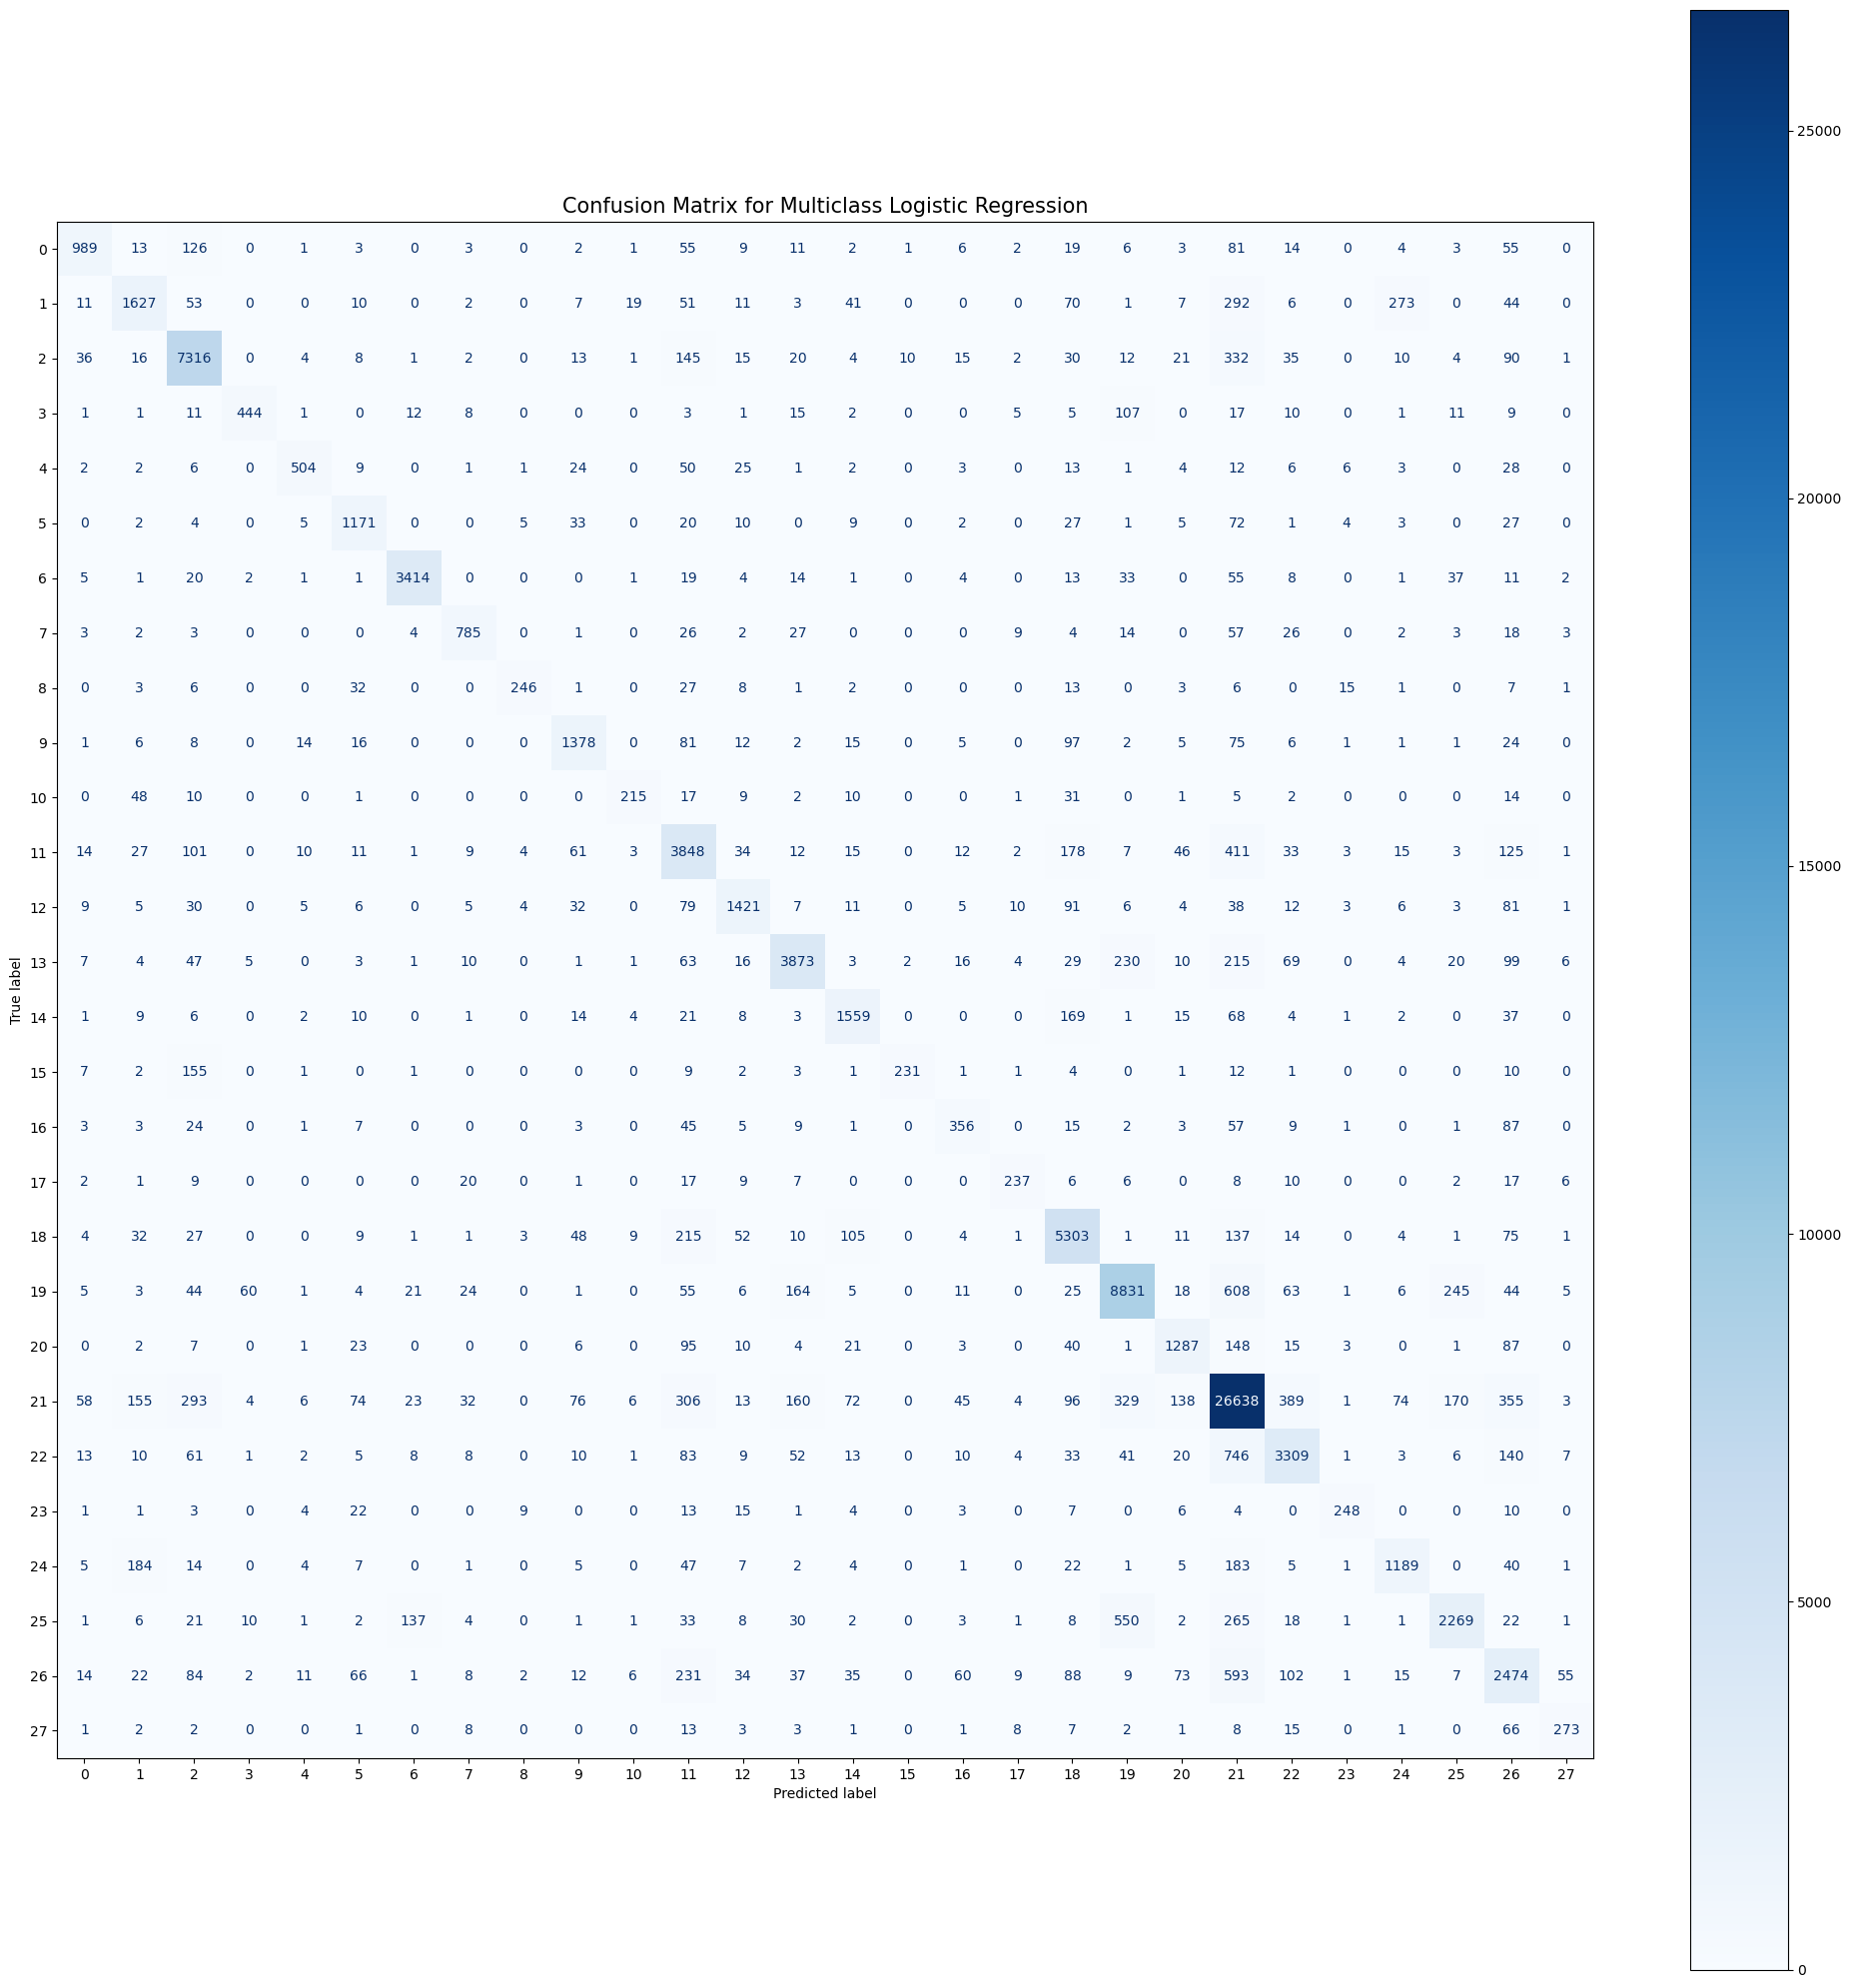

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_estimator(pipe_ft, X_test, y_test, cmap='Blues', ax= ax)
plt.title("Confusion Matrix for Multiclass Logistic Regression", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
male_mask = s_test == 0
female_mask = s_test == 1

male_test_y = y_test[male_mask]
female_test_y = y_test[female_mask]

male_ypred = y_pred[male_mask]
female_ypred = y_pred[female_mask]

print("\nMale Classification Report of Tuned Baseline Logistic Regression Classifier")
print(classification_report(male_ypred, male_test_y))
print("_"*110)
print("\nFemale Classification Report of Tuned Baseline Logistic Regression Classifier")
print(classification_report(female_ypred, female_test_y))


Male Classification Report of Tuned Baseline Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       737
           1       0.64      0.76      0.69      1624
           2       0.90      0.87      0.89      5195
           3       0.69      0.85      0.76       395
           4       0.73      0.88      0.79       460
           5       0.83      0.80      0.82      1213
           6       0.93      0.94      0.94      2337
           7       0.59      0.46      0.52        91
           8       0.68      0.91      0.78       238
           9       0.79      0.81      0.80      1152
          10       0.55      0.61      0.58        64
          11       0.76      0.65      0.70      2962
          12       0.41      0.42      0.41       317
          13       0.77      0.71      0.74       471
          14       0.81      0.80      0.81      1069
          15       0.36      0.86      0.51        28
    

In [ ]:
def class_accuracy(y_pred, y_true):
    accuracy = []
    for c in range(28):
        mask = y_true == c
        accuracy.append(accuracy_score(y_true[mask], y_pred[mask]))
    return accuracy

total_accuracy = class_accuracy(y_pred, y_test)
male_accuracy = class_accuracy(male_ypred, male_test_y)
female_accuracy = class_accuracy(female_ypred, female_test_y)
diff_accuracy = np.array(male_accuracy) - np.array(female_accuracy)
absdiff_accuracy = np.abs(diff_accuracy)

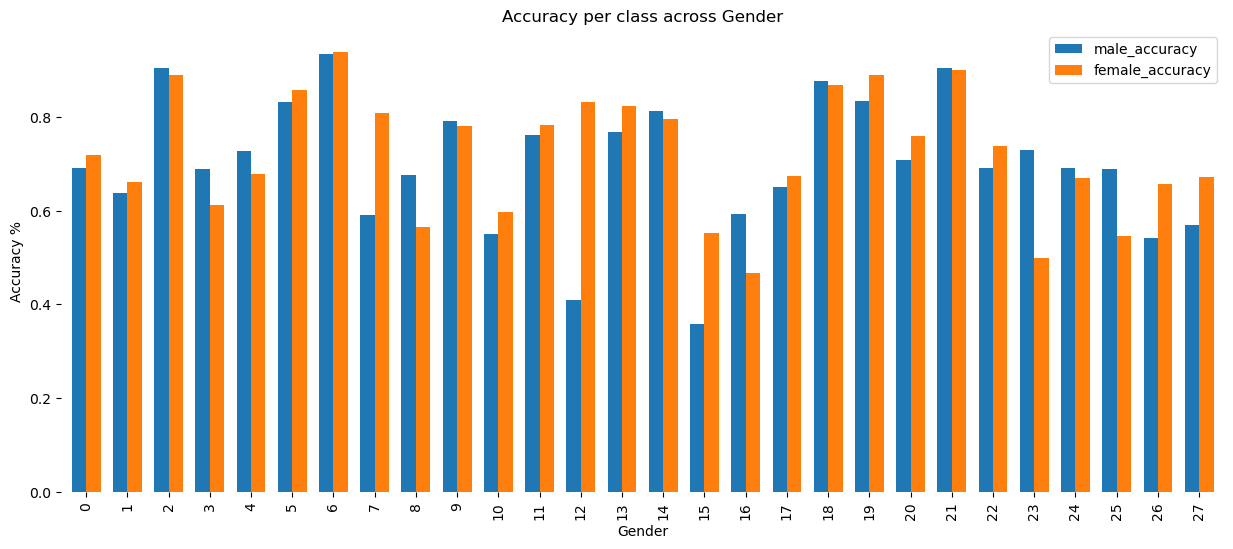

In [ ]:
group = list(range(28))
accuracy_df = pd.DataFrame({
    "group" : group,
    "male_accuracy": male_accuracy,
    "female_accuracy": female_accuracy
})

accuracy_df.set_index('group').plot(kind='bar',
                                    width=0.7,
                                    figsize=(15, 6),
                                    title ="Accuracy per class across Gender",
                                    ylabel = "Accuracy %",
                                    xlabel = "Gender"
                                   )
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)

# BERT Classifier Setup and Data Preparation

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA GeForce RTX 3070 Ti


In [ ]:
!pip install transformers datasets torch accelerate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Using the same train/val/test splits as the Logistic Regression baseline
# This ensures fair comparison between models
X_train = pd.read_csv("X_train.csv")['clean_text']
y_train = pd.read_csv("y_train.csv")['profession']
s_train = pd.read_csv("s_train.csv")['gender']

X_val = pd.read_csv("X_val.csv")['clean_text']
y_val = pd.read_csv("y_val.csv")['profession']
s_val = pd.read_csv("s_val.csv")['gender']

X_test = pd.read_csv("X_test.csv")['clean_text']
y_test = pd.read_csv("y_test.csv")['profession']
s_test = pd.read_csv("s_test.csv")['gender']

# Print shapes to verify loading
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (257478,)
Validation data shape: (39642,)
Test data shape: (99069,)


In [ ]:
# Define a custom Dataset class for BERT (this prepares the data for tokenization)
class BiasBiosDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.values  # Convert Series to numpy array for indexing
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dim
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = BiasBiosDataset(X_train, y_train, tokenizer)
val_dataset = BiasBiosDataset(X_val, y_val, tokenizer)
test_dataset = BiasBiosDataset(X_test, y_test, tokenizer)

sample = train_dataset[0]
print("\nSample input IDs shape:", sample['input_ids'].shape)
print("Sample label:", sample['labels'])


Sample input IDs shape: torch.Size([128])
Sample label: tensor(21)


In [ ]:
# Number of labels (28 professions)
num_labels = 28

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./bert_logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
    seed=42,
)

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Mario\AppData\Local\Temp\ipykernel_13380\2655647559.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine-tune
trainer.train()

# Save model and tokenizer
trainer.save_model('./bert_finetuned')
tokenizer.save_pretrained('./bert_finetuned')

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.484100,0.528258,0.845265,0.781923
2,0.416500,0.510867,0.853236,0.805493
3,0.250500,0.573679,0.857878,0.809604


('./bert_finetuned\\tokenizer_config.json',
 './bert_finetuned\\special_tokens_map.json',
 './bert_finetuned\\vocab.txt',
 './bert_finetuned\\added_tokens.json')

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("BERT Test Results:", test_results)

BERT Test Results: {'eval_loss': 0.5644915103912354, 'eval_accuracy': 0.8598552523998425, 'eval_f1': 0.8107790181971144, 'eval_runtime': 287.6714, 'eval_samples_per_second': 344.383, 'eval_steps_per_second': 21.525, 'epoch': 3.0}


In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=-1)

# Convert to numpy
y_test_np = y_test.to_numpy()
y_pred_np = y_pred

# Overall metrics
print("BERT Final Test Accuracy Post Fine-Tuning")
print("Accuracy:", accuracy_score(y_test_np, y_pred_np))
print("F1 Score (macro):", f1_score(y_test_np, y_pred_np, average='macro'))
print(classification_report(y_test_np, y_pred_np))

# Gender-specific
male_mask = s_test == 0
female_mask = s_test == 1

male_test_y = y_test_np[male_mask]
female_test_y = y_test_np[female_mask]

male_ypred = y_pred_np[male_mask]
female_ypred = y_pred_np[female_mask]

print("\nMale Classification Report for BERT Classifier")
print(classification_report(male_test_y, male_ypred))
print("_" * 110)
print("\nFemale Classification Report for BERT Classifier")
print(classification_report(female_test_y, female_ypred))

BERT Final Test Accuracy Post Fine-Tuning
Accuracy: 0.8598552523998425
F1 Score (macro): 0.8107790181971144
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1409
           1       0.77      0.70      0.74      2528
           2       0.90      0.92      0.91      8143
           3       0.80      0.70      0.75       664
           4       0.86      0.83      0.84       703
           5       0.85      0.89      0.87      1401
           6       0.95      0.95      0.95      3647
           7       0.86      0.86      0.86       989
           8       0.82      0.80      0.81       372
           9       0.86      0.83      0.84      1750
          10       0.75      0.73      0.74       366
          11       0.78      0.81      0.79      4986
          12       0.86      0.82      0.84      1874
          13       0.88      0.85      0.86      4738
          14       0.84      0.84      0.84      1935
          15       0.81    

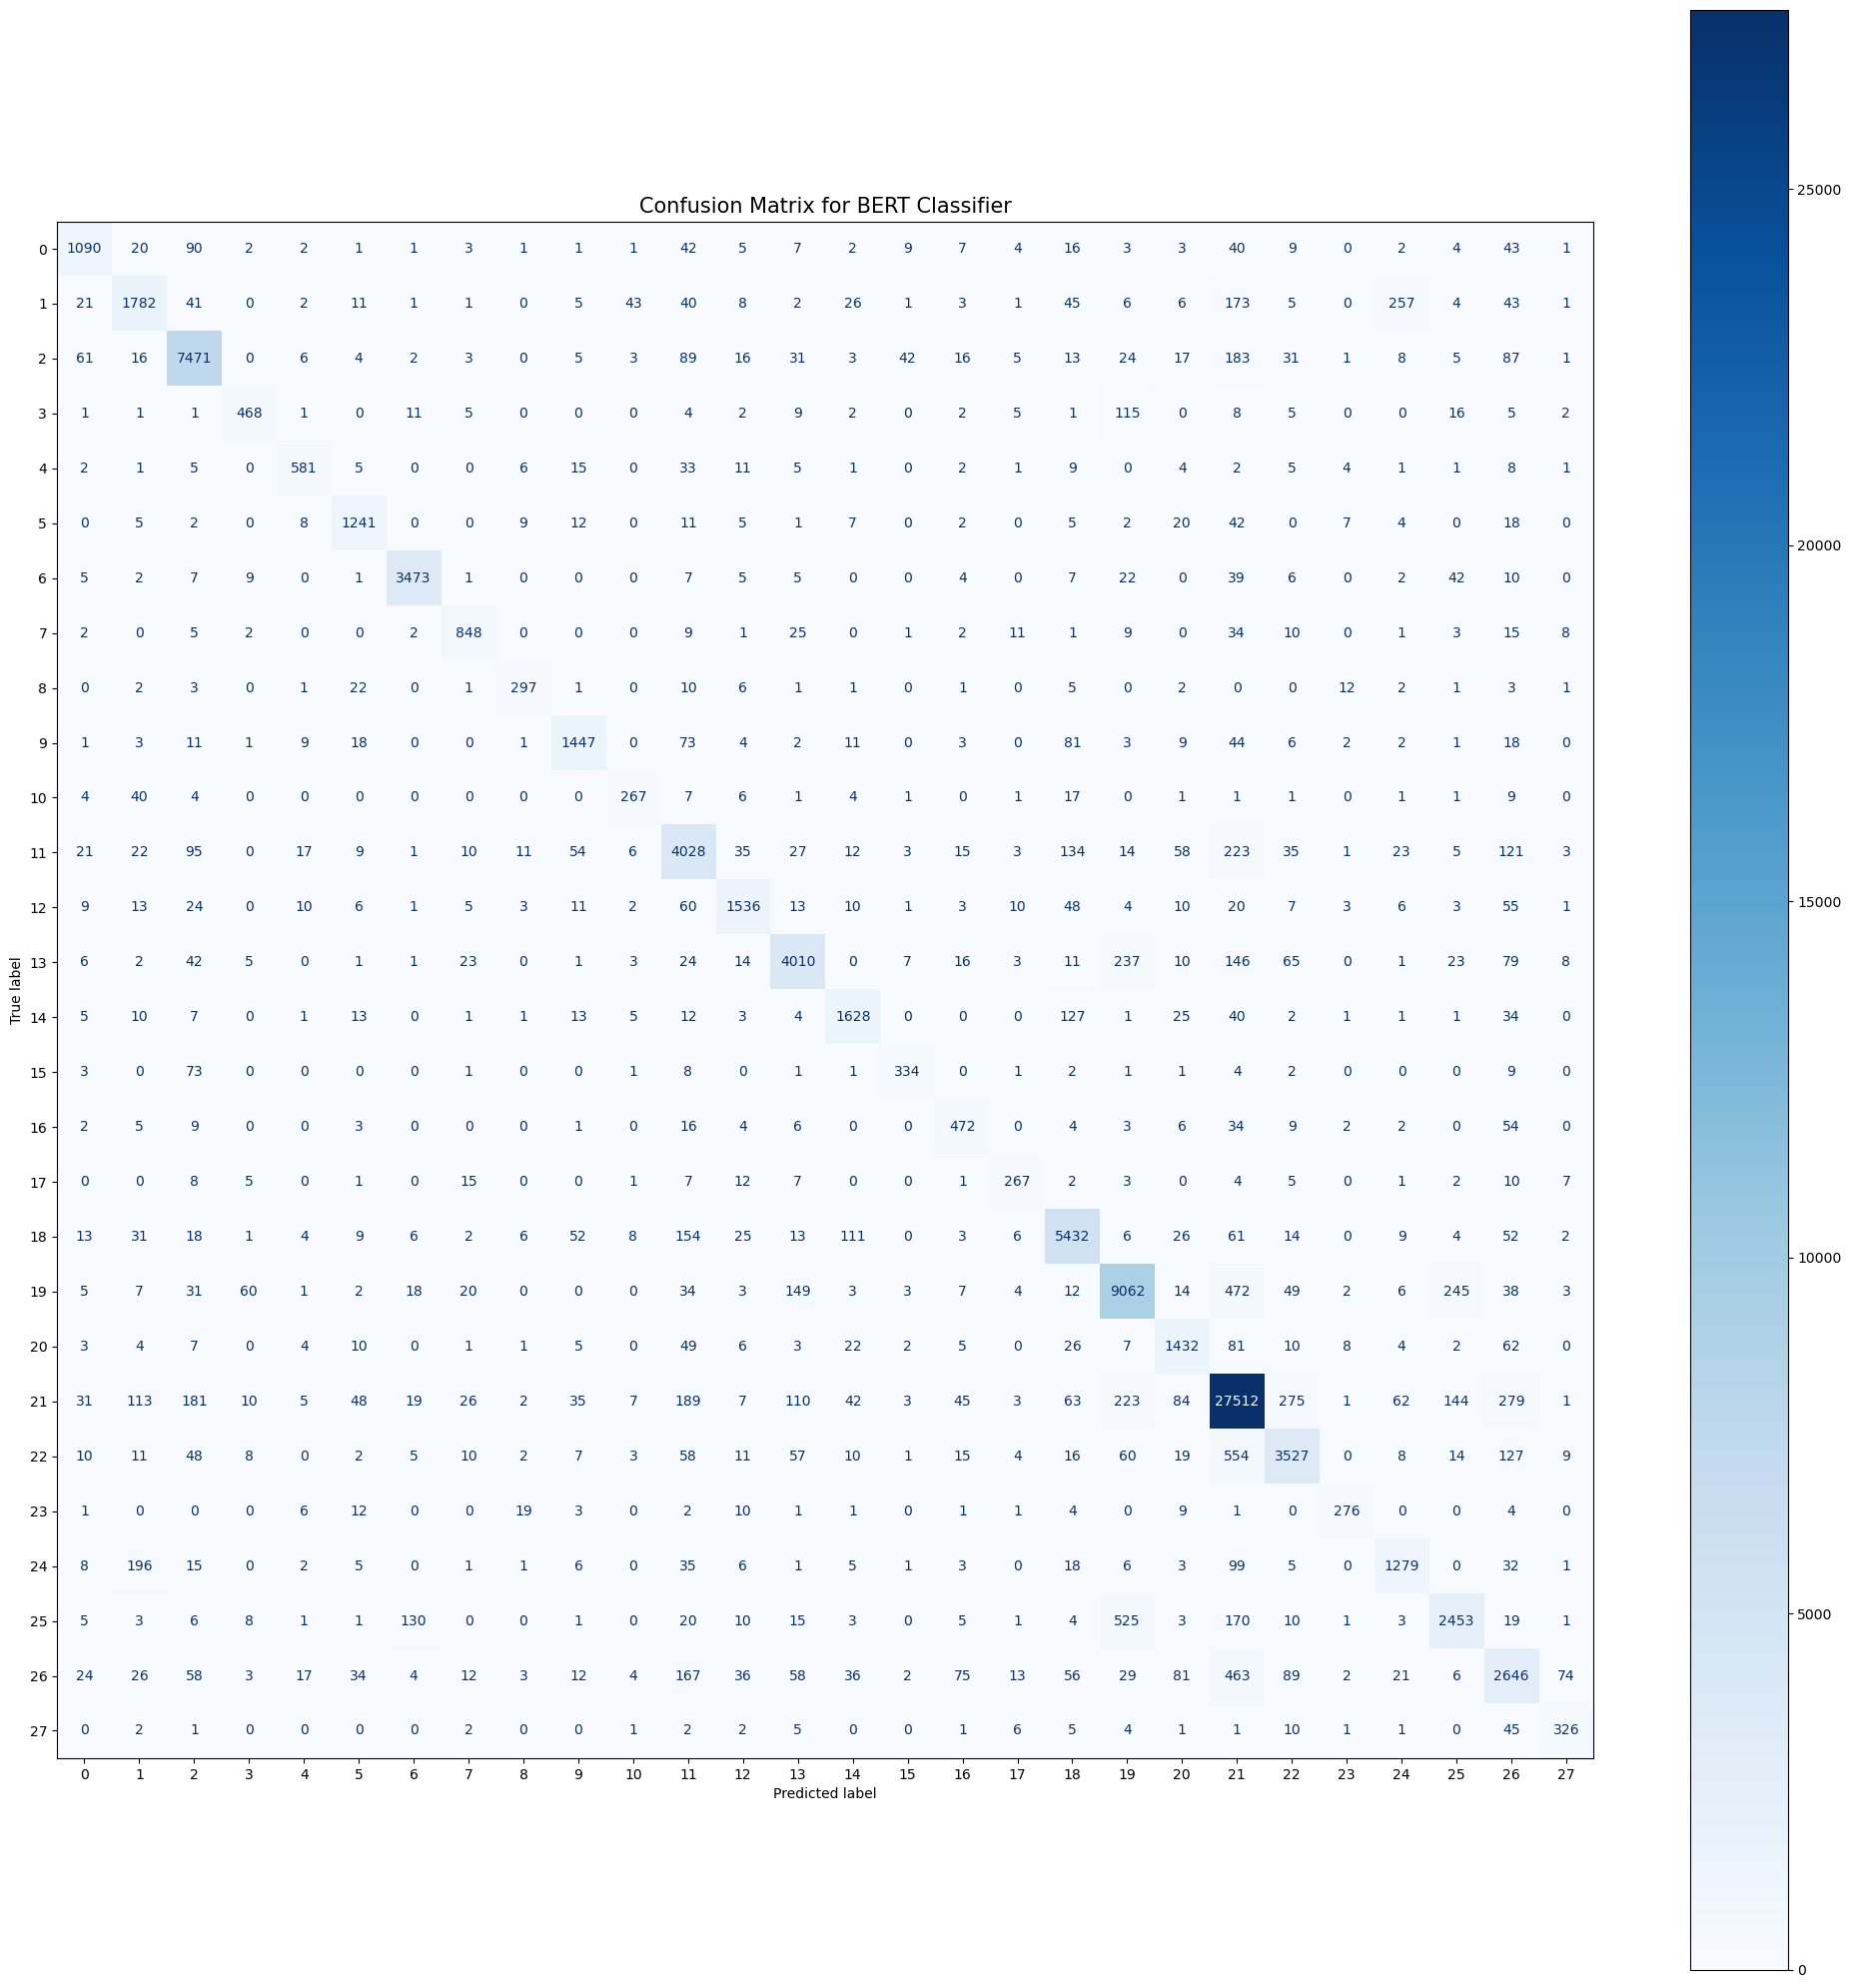

In [ ]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_np, cmap='Blues', ax=ax)
plt.title("Confusion Matrix for BERT Classifier", fontsize=15)
plt.tight_layout()
plt.show()

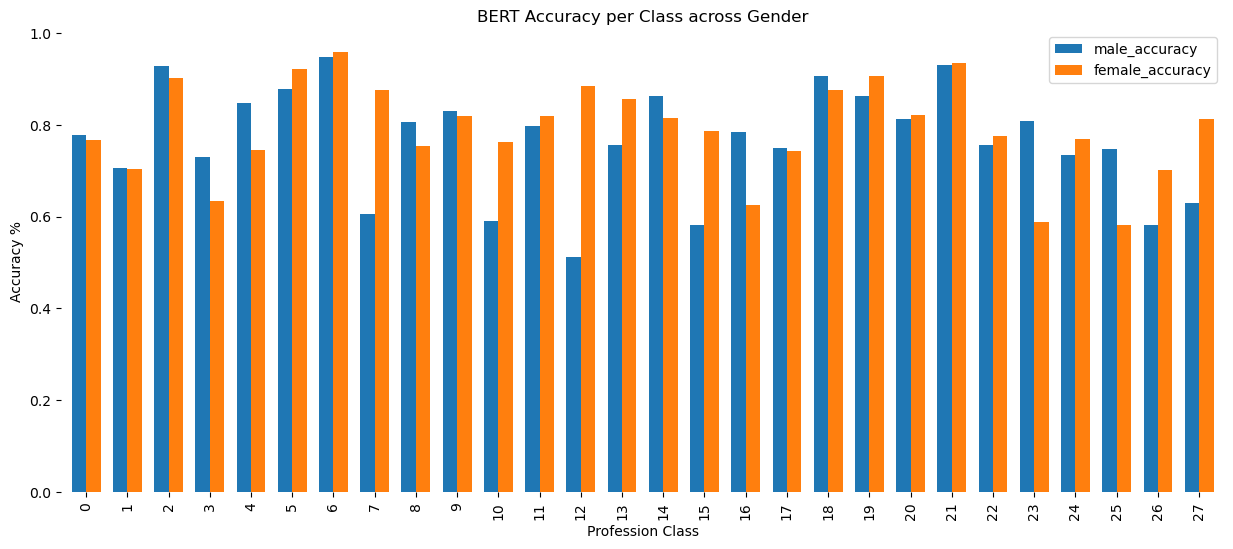

In [ ]:
# Per-class accuracy function
def class_accuracy(y_pred, y_true):
    accuracy = []
    for c in range(num_labels):
        mask = y_true == c
        if mask.sum() > 0:
            accuracy.append(accuracy_score(y_true[mask], y_pred[mask]))
        else:
            accuracy.append(0.0)
    return accuracy

male_accuracy = class_accuracy(male_ypred, male_test_y)
female_accuracy = class_accuracy(female_ypred, female_test_y)

# DataFrame and plot
accuracy_df = pd.DataFrame({
    "group": list(range(num_labels)),
    "male_accuracy": male_accuracy,
    "female_accuracy": female_accuracy
})

accuracy_df.set_index('group').plot(kind='bar', width=0.7, figsize=(15, 6))
plt.title("BERT Accuracy per Class across Gender")
plt.ylabel("Accuracy %")
plt.xlabel("Profession Class")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)
plt.show()

# Load CFA Data and Create Datasets

In [ ]:
# Load CFA val data
X_val_cfa = pd.read_csv("x_val_cfa.csv")['clean_text']
y_val_cfa = pd.read_csv("y_val_cfa.csv")['profession']
s_val_cfa = pd.read_csv("s_val_cfa.csv")['cfa_gender']

# Load CFA test data
X_test_cfa = pd.read_csv("x_test_cfa.csv")['clean_text']
y_test_cfa = pd.read_csv("y_test_cfa.csv")['profession']
s_test_cfa = pd.read_csv("s_test_cfa.csv")['cfa_gender']

# Print shapes
print("CFA Validation data shape:", X_val_cfa.shape)
print("CFA Test data shape:", X_test_cfa.shape)

# Create CFA datasets
val_dataset_cfa = BiasBiosDataset(X_val_cfa, y_val_cfa, tokenizer)
test_dataset_cfa = BiasBiosDataset(X_test_cfa, y_test_cfa, tokenizer)

# CFA gender masks
male_mask_cfa = s_test_cfa == 0
female_mask_cfa = s_test_cfa == 1
male_test_y_cfa = y_test_cfa.to_numpy()[male_mask_cfa]
female_test_y_cfa = y_test_cfa.to_numpy()[female_mask_cfa]
y_test_cfa_np = y_test_cfa.to_numpy()

CFA Validation data shape: (39642,)
CFA Test data shape: (99069,)


Original BERT Test Results on CFA Data: {'eval_loss': 0.5988409519195557, 'eval_accuracy': 0.8537685855312964, 'eval_f1': 0.7990801719937101, 'eval_runtime': 304.5116, 'eval_samples_per_second': 325.337, 'eval_steps_per_second': 20.334, 'epoch': 3.0}
Original BERT Final Test Accuracy on CFA Data
Accuracy: 0.8537685855312964
F1 Score (macro): 0.7990801719937101
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1409
           1       0.78      0.67      0.72      2528
           2       0.90      0.92      0.91      8143
           3       0.82      0.65      0.73       664
           4       0.84      0.80      0.82       703
           5       0.86      0.87      0.87      1401
           6       0.94      0.95      0.95      3647
           7       0.87      0.82      0.85       989
           8       0.80      0.79      0.79       372
           9       0.85      0.82      0.84      1750
          10       0.71      0.67      0.6

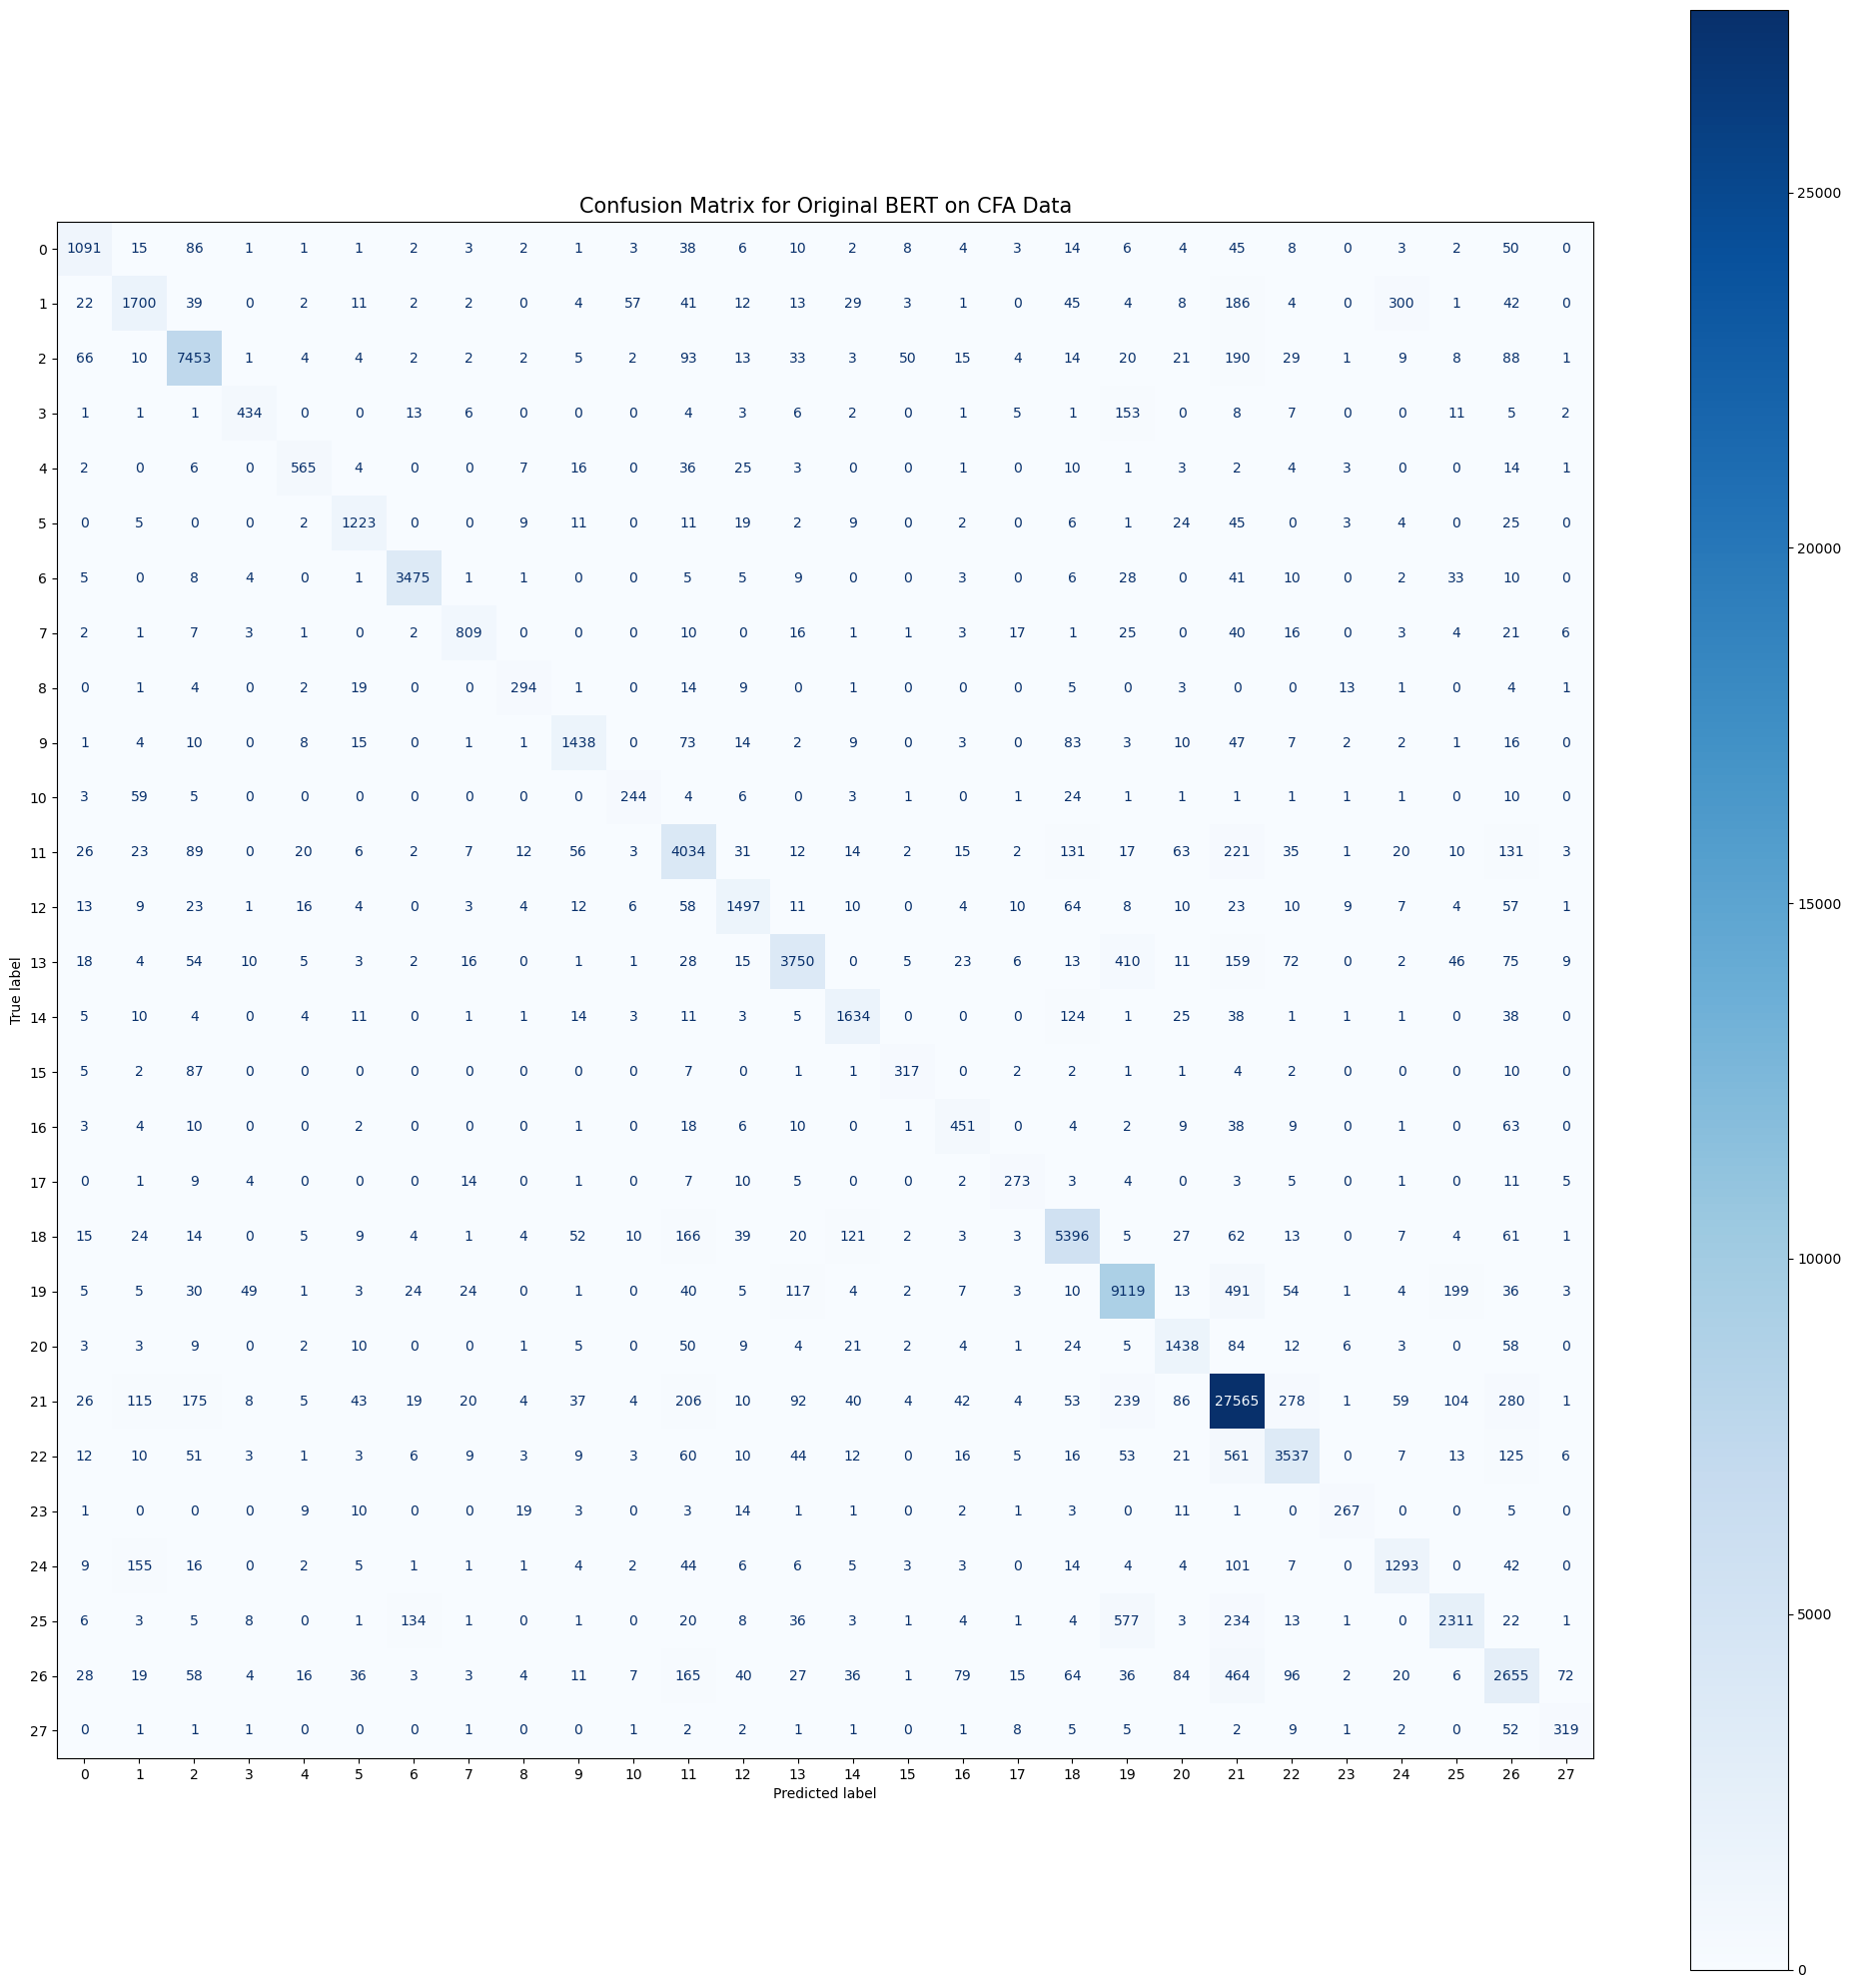

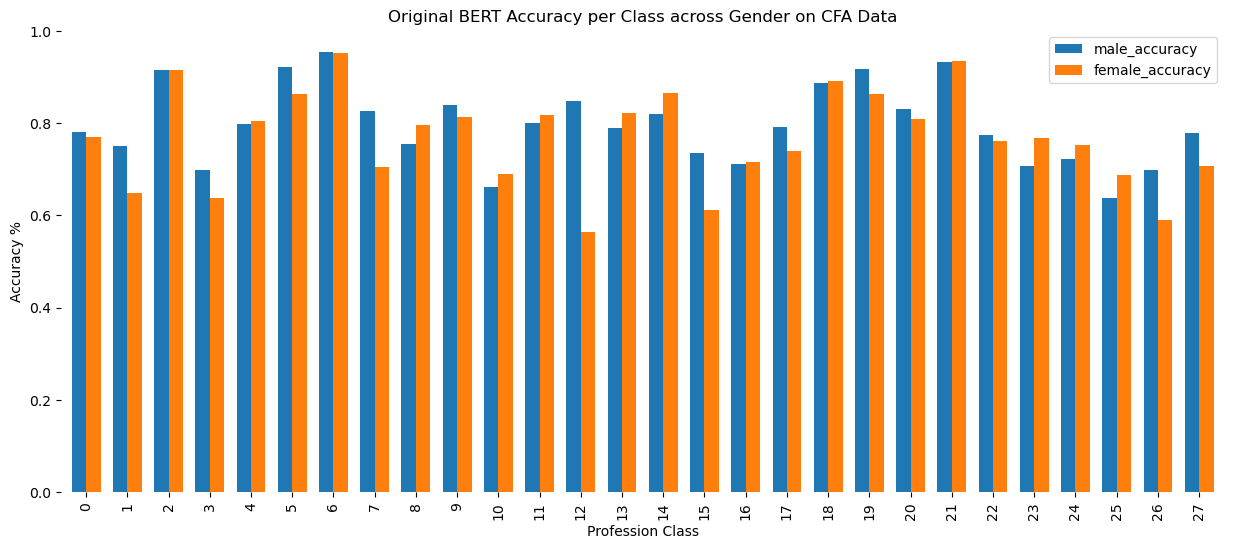

In [ ]:
# Evaluate original BERT on CFA test
test_results_cfa = trainer.evaluate(test_dataset_cfa)
print("Original BERT Test Results on CFA Data:", test_results_cfa)

# Predictions
predictions_cfa = trainer.predict(test_dataset_cfa)
y_pred_cfa = np.argmax(predictions_cfa.predictions, axis=-1)

# Overall metrics
print("Original BERT Final Test Accuracy on CFA Data")
print("Accuracy:", accuracy_score(y_test_cfa_np, y_pred_cfa))
print("F1 Score (macro):", f1_score(y_test_cfa_np, y_pred_cfa, average='macro'))
print(classification_report(y_test_cfa_np, y_pred_cfa))

# Gender-specific
male_ypred_cfa = y_pred_cfa[male_mask_cfa]
female_ypred_cfa = y_pred_cfa[female_mask_cfa]

print("\nMale Classification Report for Original BERT on CFA Data")
print(classification_report(male_test_y_cfa, male_ypred_cfa))
print("_" * 110)
print("\nFemale Classification Report for Original BERT on CFA Data")
print(classification_report(female_test_y_cfa, female_ypred_cfa))

# Confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_test_cfa_np, y_pred_cfa, cmap='Blues', ax=ax)
plt.title("Confusion Matrix for Original BERT on CFA Data", fontsize=15)
plt.tight_layout()
plt.show()

# Per-class accuracy plot
male_accuracy_orig_cfa = class_accuracy(male_ypred_cfa, male_test_y_cfa)
female_accuracy_orig_cfa = class_accuracy(female_ypred_cfa, female_test_y_cfa)

accuracy_df_orig_cfa = pd.DataFrame({
    "group": list(range(num_labels)),
    "male_accuracy": male_accuracy_orig_cfa,
    "female_accuracy": female_accuracy_orig_cfa
})

accuracy_df_orig_cfa.set_index('group').plot(kind='bar', width=0.7, figsize=(15, 6))
plt.title("Original BERT Accuracy per Class across Gender on CFA Data")
plt.ylabel("Accuracy %")
plt.xlabel("Profession Class")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)
plt.show()

# Generate CFA-Augmented Train Data

In [ ]:
import re

# Gender pairs
gender_pairs = [
    ('he', 'she'), ('him', 'her'), ('his', 'her'), ('himself', 'herself'),
    ('male', 'female'), ('man', 'woman'), ('men', 'women'),
    ('mr', 'ms'), ('mr.', 'ms.'), ('mrs', 'mr'), ('mrs.', 'mr.'),
    ('boy', 'girl'), ('boys', 'girls'), ('boyfriend', 'girlfriend'),
    ('father', 'mother'), ('husband', 'wife'), ('son', 'daughter'),
    ('brother', 'sister'), ('uncle', 'aunt'), ('nephew', 'niece')
]

# Swap dict
swap_dict = {}
for m, f in gender_pairs:
    swap_dict[m] = f
    swap_dict[f] = m
    swap_dict[m.capitalize()] = f.capitalize()
    swap_dict[f.capitalize()] = m.capitalize()
    swap_dict[m.upper()] = f.upper()
    swap_dict[f.upper()] = m.upper()

# Swap function
def swap_gender_terms(text):
    def replace(match):
        word = match.group(0)
        return swap_dict.get(word, word)
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in swap_dict.keys()) + r')\b', re.IGNORECASE)
    return pattern.sub(replace, text)

# Generate
print("Generating Counterfactual Training Data...")
X_train_cfa = X_train.apply(swap_gender_terms)

# Augment
X_train_augmented = pd.concat([X_train, X_train_cfa], ignore_index=True)
y_train_augmented = pd.concat([y_train, y_train], ignore_index=True)
s_train_augmented = pd.concat([s_train, 1 - s_train], ignore_index=True)

print(f"Original Training Size: {len(X_train)}")
print(f"Augmented Training Size: {len(X_train_augmented)}")

# Save
X_train_augmented.to_frame('clean_text').to_csv("X_train_cfa_augmented.csv", index=False)
y_train_augmented.to_frame('profession').to_csv("y_train_cfa_augmented.csv", index=False)
s_train_augmented.to_frame('gender').to_csv("s_train_cfa_augmented.csv", index=False)
print("Augmented train data saved.")

Generating Counterfactual Training Data...
Original Training Size: 257478
Augmented Training Size: 514956
Augmented train data saved.


# Create and Retrain BERT on CFA-Augmented Train

In [ ]:
# Augmented dataset
train_dataset_augmented = BiasBiosDataset(X_train_augmented, y_train_augmented, tokenizer)

# New model
model_cfa = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model_cfa.to(device)

# Training args
training_args_cfa = TrainingArguments(
    output_dir='./bert_cfa_results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./bert_cfa_logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    fp16=True if torch.cuda.is_available() else False,
    seed=42,
)

# Trainer
trainer_cfa = Trainer(
    model=model_cfa,
    args=training_args_cfa,
    train_dataset=train_dataset_augmented,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train and save
trainer_cfa.train()
trainer_cfa.save_model('./bert_cfa_finetuned')
tokenizer.save_pretrained('./bert_cfa_finetuned')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Mario\AppData\Local\Temp\ipykernel_13380\1728514763.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cfa = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.388300,0.527825,0.851496,0.801741
2,0.146500,0.677155,0.854447,0.803410


('./bert_cfa_finetuned\\tokenizer_config.json',
 './bert_cfa_finetuned\\special_tokens_map.json',
 './bert_cfa_finetuned\\vocab.txt',
 './bert_cfa_finetuned\\added_tokens.json')

# Evaluate CFA-Trained BERT on Original Test

CFA-Trained BERT Test Results on Original Data: {'eval_loss': 0.680898129940033, 'eval_accuracy': 0.8531932289616329, 'eval_f1': 0.8027807275937214, 'eval_runtime': 293.1452, 'eval_samples_per_second': 337.952, 'eval_steps_per_second': 21.123, 'epoch': 2.0}
CFA-Trained BERT Final Test Accuracy on Original Data
Accuracy: 0.8531932289616329
F1 Score (macro): 0.8027807275937214
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1409
           1       0.73      0.72      0.73      2528
           2       0.89      0.91      0.90      8143
           3       0.79      0.71      0.75       664
           4       0.82      0.81      0.81       703
           5       0.85      0.87      0.86      1401
           6       0.94      0.95      0.95      3647
           7       0.84      0.86      0.85       989
           8       0.81      0.80      0.81       372
           9       0.84      0.83      0.84      1750
          10       0.79    

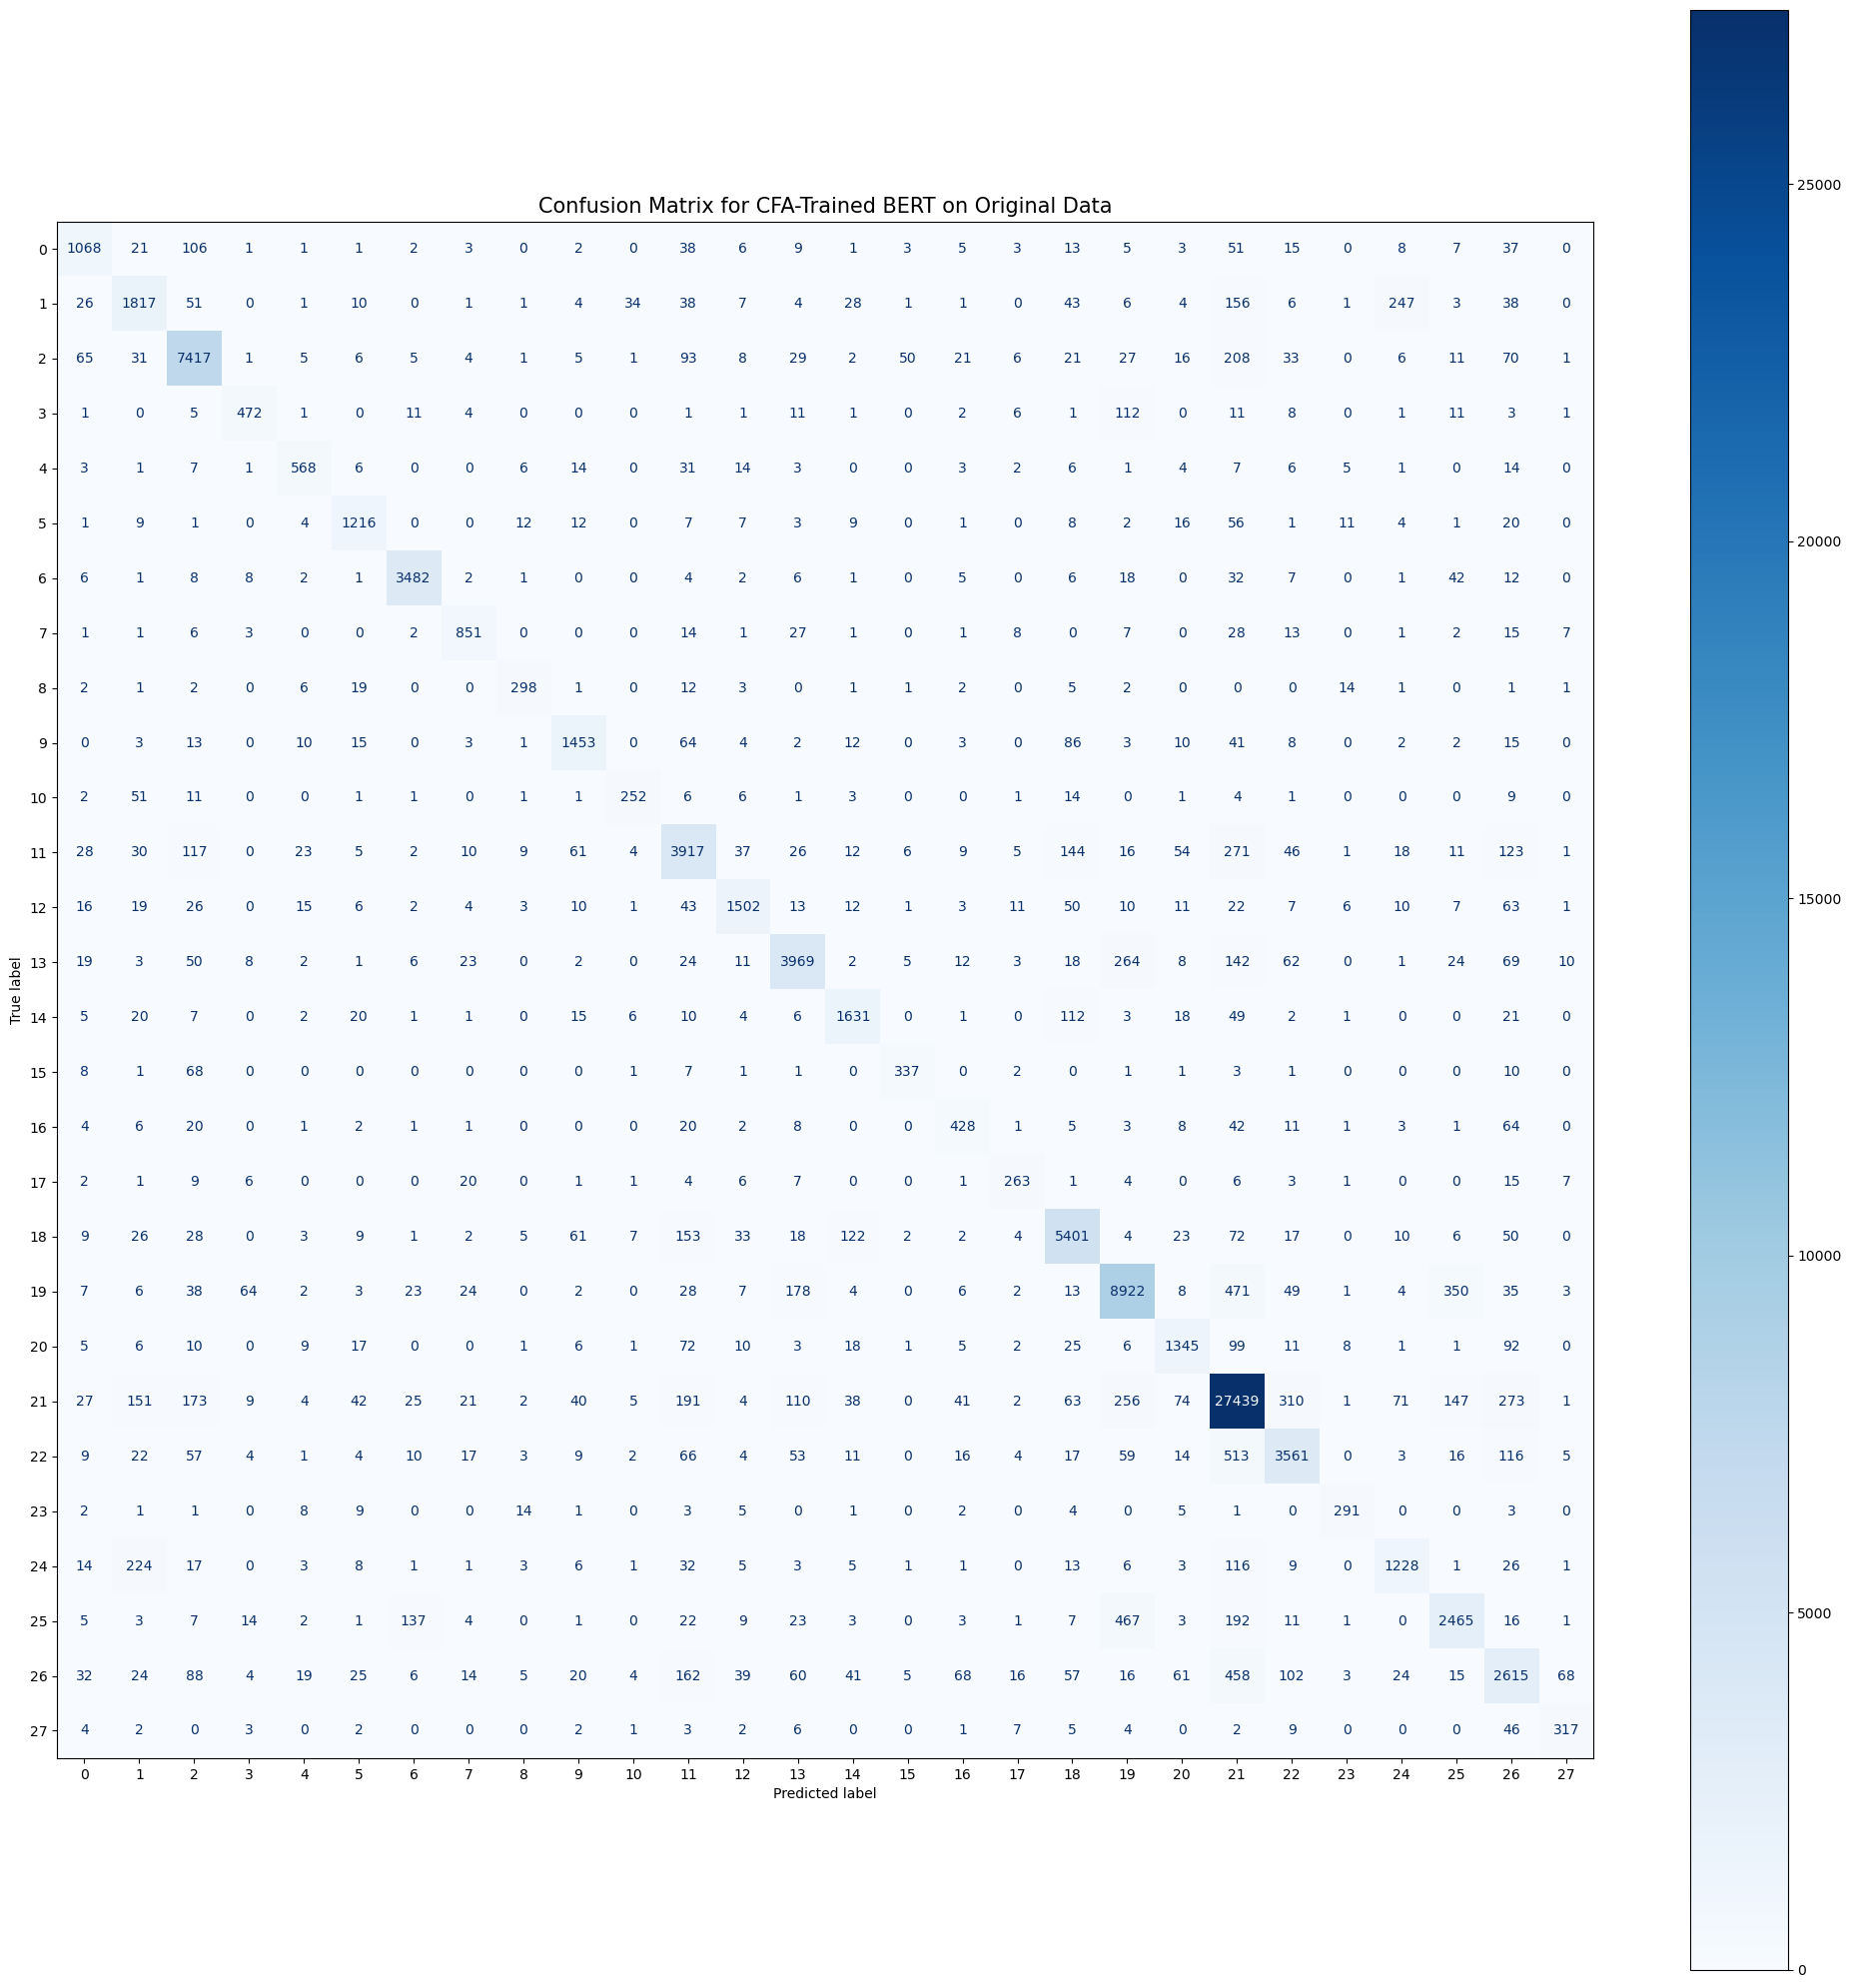

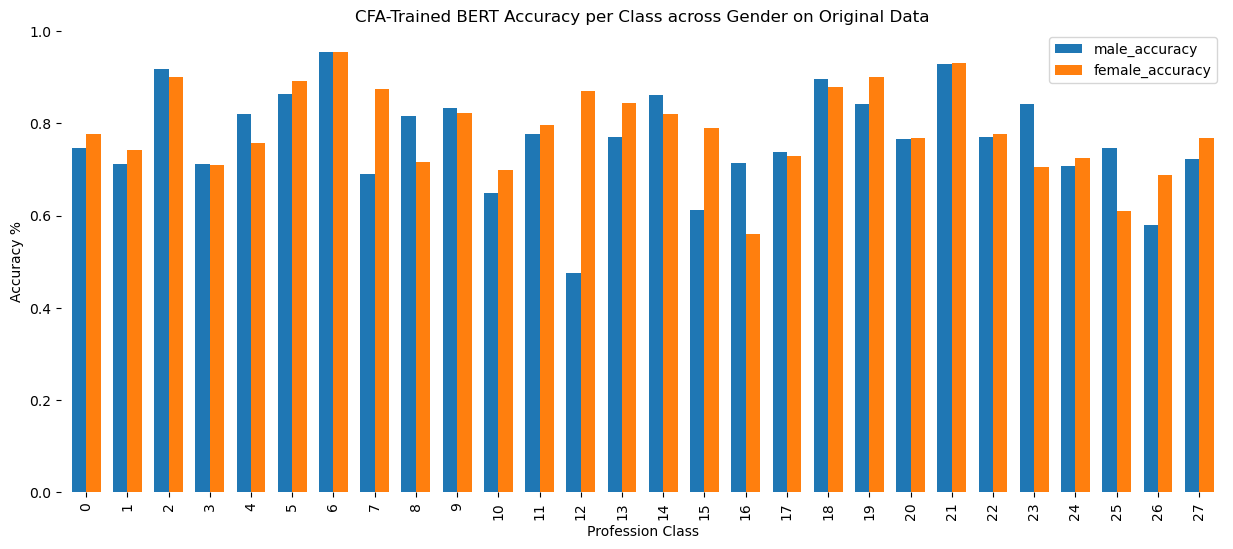

In [ ]:
# Evaluate
test_results_cfa_orig = trainer_cfa.evaluate(test_dataset)
print("CFA-Trained BERT Test Results on Original Data:", test_results_cfa_orig)

# Predictions
predictions_cfa_orig = trainer_cfa.predict(test_dataset)
y_pred_cfa_orig = np.argmax(predictions_cfa_orig.predictions, axis=-1)

# Metrics
print("CFA-Trained BERT Final Test Accuracy on Original Data")
print("Accuracy:", accuracy_score(y_test_np, y_pred_cfa_orig))
print("F1 Score (macro):", f1_score(y_test_np, y_pred_cfa_orig, average='macro'))
print(classification_report(y_test_np, y_pred_cfa_orig))

# Gender-specific
male_ypred_cfa_orig = y_pred_cfa_orig[male_mask]
female_ypred_cfa_orig = y_pred_cfa_orig[female_mask]

print("\nMale Classification Report for CFA-Trained BERT on Original Data")
print(classification_report(male_test_y, male_ypred_cfa_orig))
print("_" * 110)
print("\nFemale Classification Report for CFA-Trained BERT on Original Data")
print(classification_report(female_test_y, female_ypred_cfa_orig))

# Confusion
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_cfa_orig, cmap='Blues', ax=ax)
plt.title("Confusion Matrix for CFA-Trained BERT on Original Data", fontsize=15)
plt.tight_layout()
plt.show()

# Per-class plot
male_accuracy_cfa_orig = class_accuracy(male_ypred_cfa_orig, male_test_y)
female_accuracy_cfa_orig = class_accuracy(female_ypred_cfa_orig, female_test_y)

accuracy_df_cfa_orig = pd.DataFrame({
    "group": list(range(num_labels)),
    "male_accuracy": male_accuracy_cfa_orig,
    "female_accuracy": female_accuracy_cfa_orig
})

accuracy_df_cfa_orig.set_index('group').plot(kind='bar', width=0.7, figsize=(15, 6))
plt.title("CFA-Trained BERT Accuracy per Class across Gender on Original Data")
plt.ylabel("Accuracy %")
plt.xlabel("Profession Class")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)
plt.show()

# Evaluate CFA-Trained BERT on CFA Test

CFA-Trained BERT Test Results on CFA Data: {'eval_loss': 0.6816704273223877, 'eval_accuracy': 0.853092289212569, 'eval_f1': 0.8023779627652116, 'eval_runtime': 295.0163, 'eval_samples_per_second': 335.809, 'eval_steps_per_second': 20.989, 'epoch': 2.0}
CFA-Trained BERT Final Test Accuracy on CFA Data
Accuracy: 0.853092289212569
F1 Score (macro): 0.8023779627652116
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1409
           1       0.74      0.72      0.73      2528
           2       0.89      0.91      0.90      8143
           3       0.78      0.71      0.74       664
           4       0.82      0.81      0.81       703
           5       0.85      0.87      0.86      1401
           6       0.94      0.96      0.95      3647
           7       0.84      0.86      0.85       989
           8       0.81      0.80      0.81       372
           9       0.84      0.83      0.84      1750
          10       0.78      0.69     

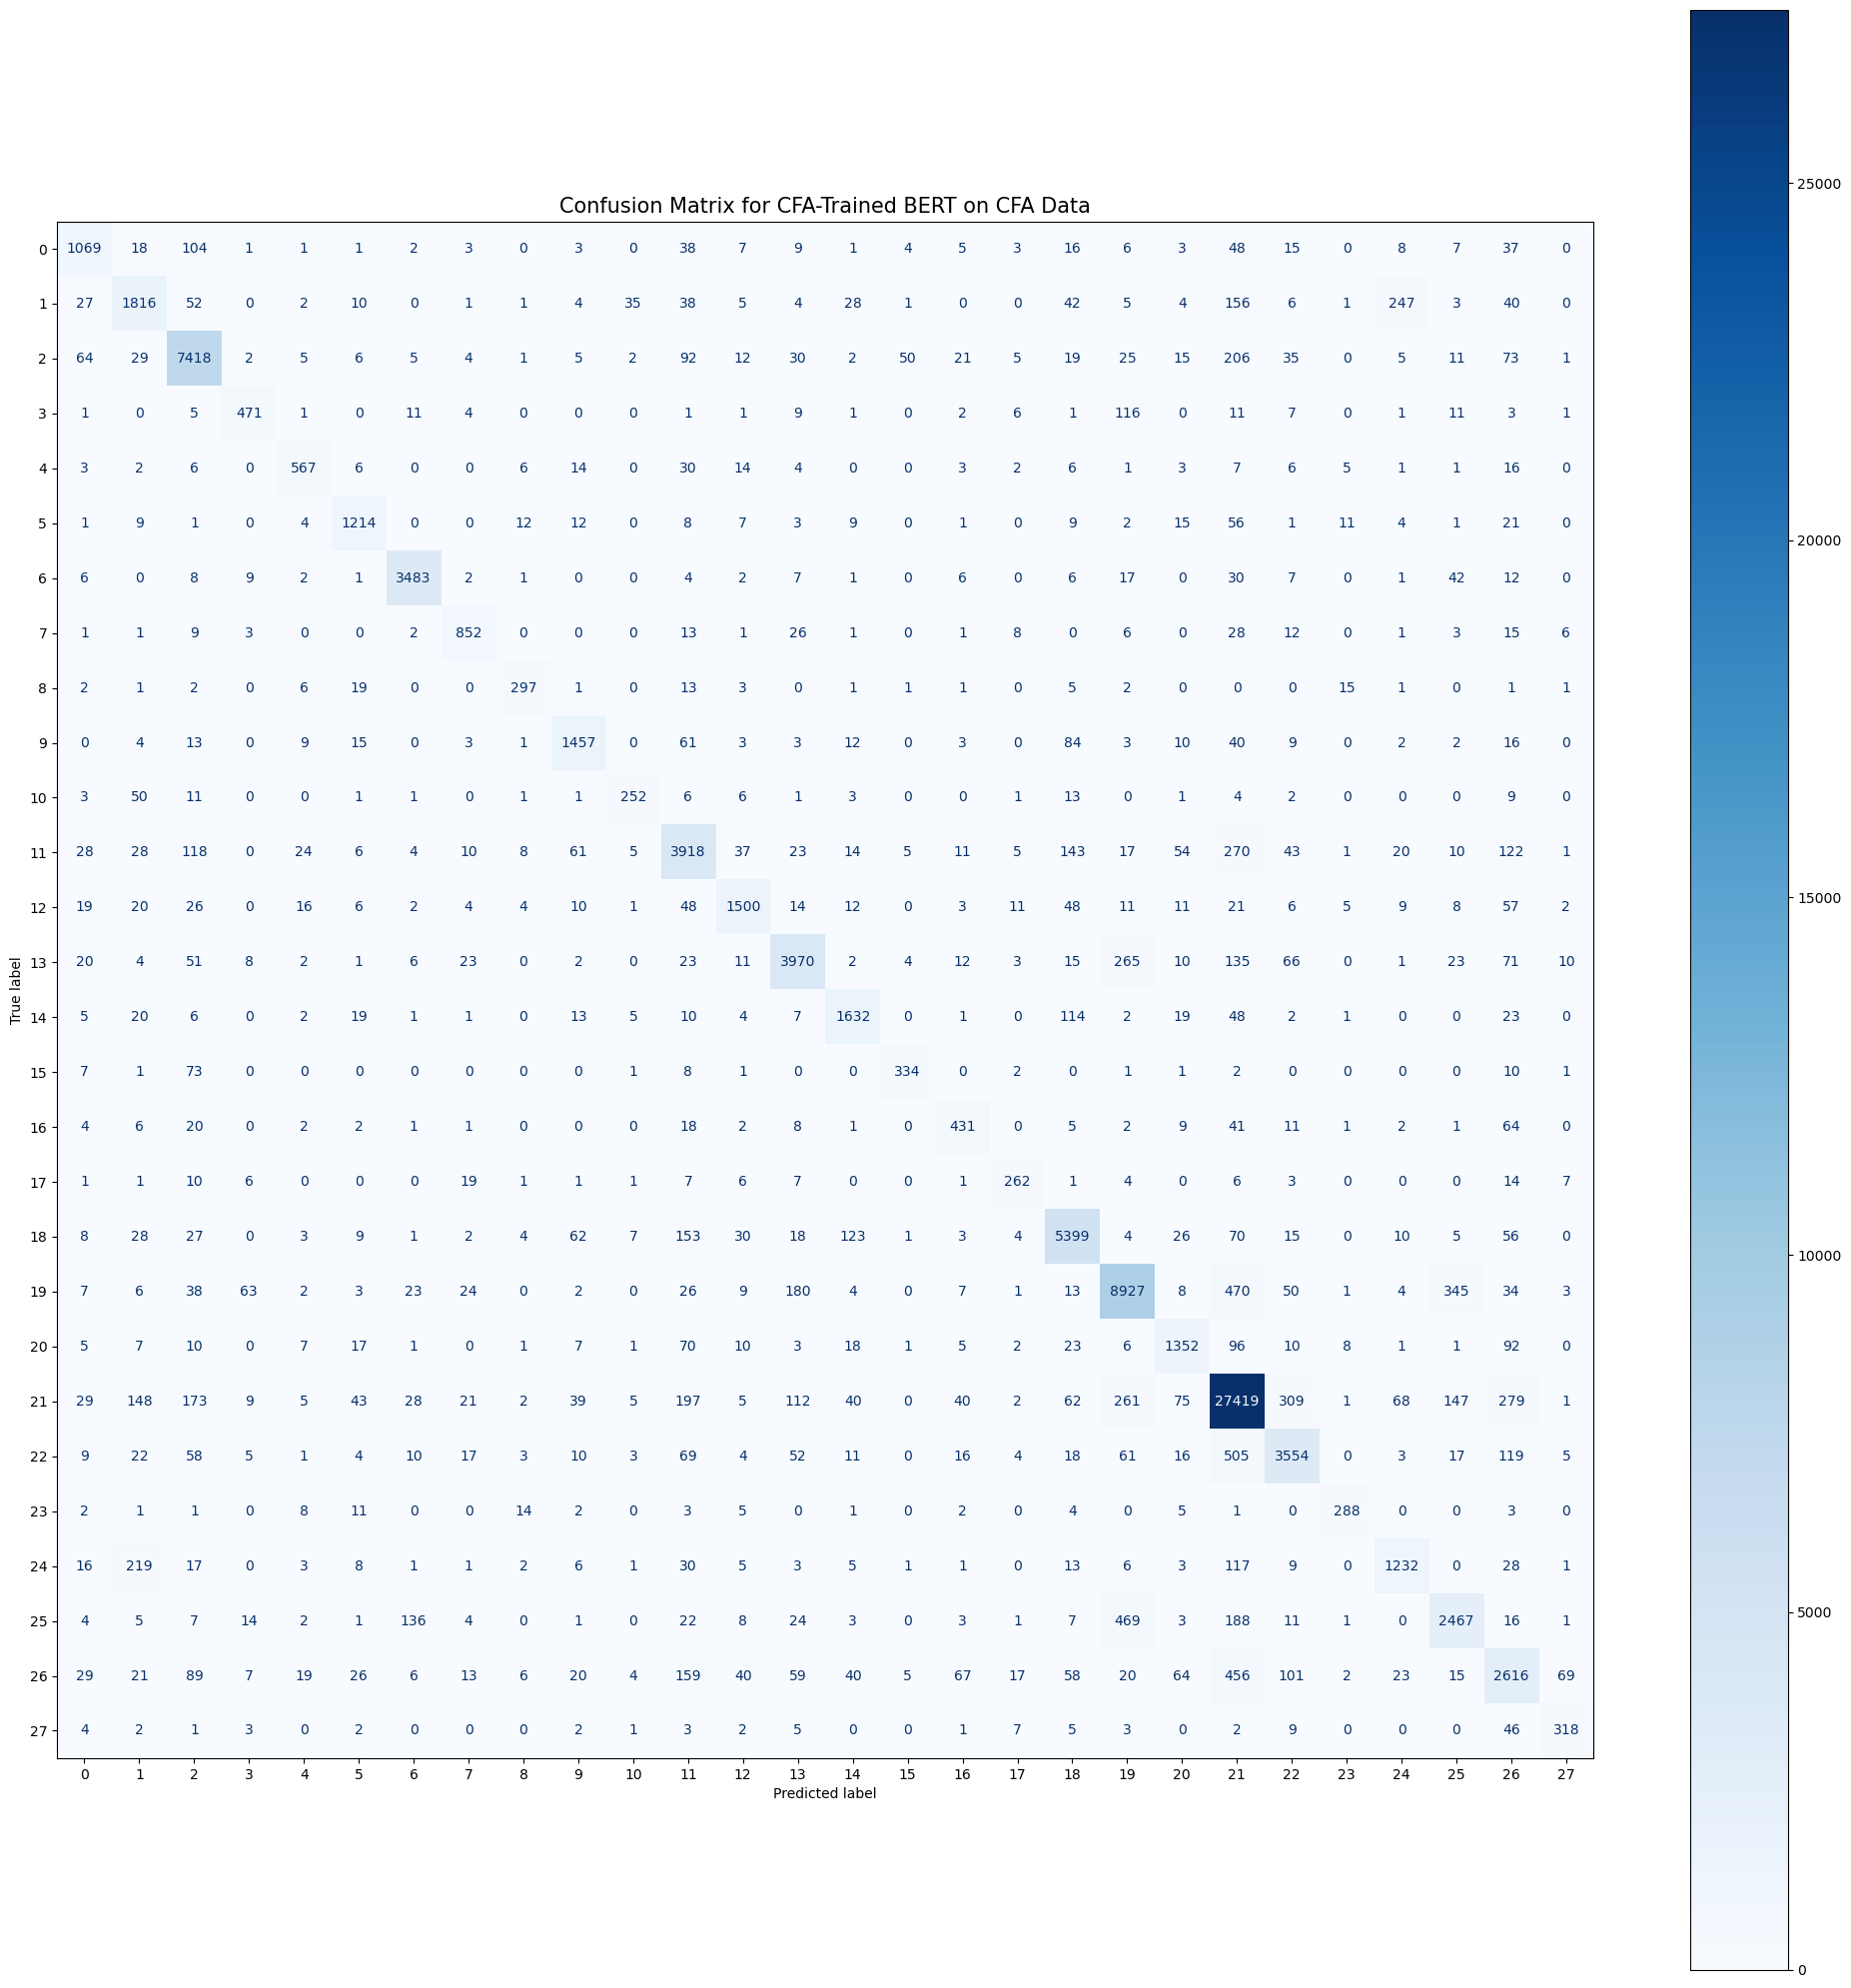

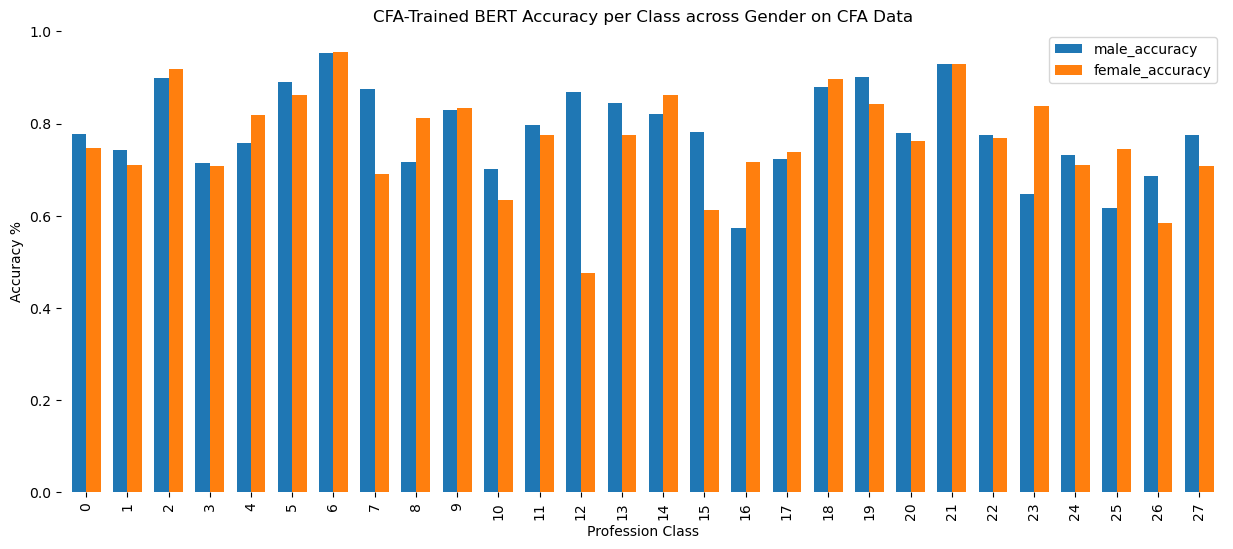

In [ ]:
# Evaluate
test_results_cfa = trainer_cfa.evaluate(test_dataset_cfa)
print("CFA-Trained BERT Test Results on CFA Data:", test_results_cfa)

# Predictions
predictions_cfa = trainer_cfa.predict(test_dataset_cfa)
y_pred_cfa = np.argmax(predictions_cfa.predictions, axis=-1)

# Metrics
print("CFA-Trained BERT Final Test Accuracy on CFA Data")
print("Accuracy:", accuracy_score(y_test_cfa_np, y_pred_cfa))
print("F1 Score (macro):", f1_score(y_test_cfa_np, y_pred_cfa, average='macro'))
print(classification_report(y_test_cfa_np, y_pred_cfa))

# Gender-specific
male_ypred_cfa = y_pred_cfa[male_mask_cfa]
female_ypred_cfa = y_pred_cfa[female_mask_cfa]

print("\nMale Classification Report for CFA-Trained BERT on CFA Data")
print(classification_report(male_test_y_cfa, male_ypred_cfa))
print("_" * 110)
print("\nFemale Classification Report for CFA-Trained BERT on CFA Data")
print(classification_report(female_test_y_cfa, female_ypred_cfa))

# Confusion
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_test_cfa_np, y_pred_cfa, cmap='Blues', ax=ax)
plt.title("Confusion Matrix for CFA-Trained BERT on CFA Data", fontsize=15)
plt.tight_layout()
plt.show()

# Per-class plot
male_accuracy_cfa = class_accuracy(male_ypred_cfa, male_test_y_cfa)
female_accuracy_cfa = class_accuracy(female_ypred_cfa, female_test_y_cfa)

accuracy_df_cfa = pd.DataFrame({
    "group": list(range(num_labels)),
    "male_accuracy": male_accuracy_cfa,
    "female_accuracy": female_accuracy_cfa
})

accuracy_df_cfa.set_index('group').plot(kind='bar', width=0.7, figsize=(15, 6))
plt.title("CFA-Trained BERT Accuracy per Class across Gender on CFA Data")
plt.ylabel("Accuracy %")
plt.xlabel("Profession Class")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)
plt.show()

# Compare Original vs. CFA-Trained BERT


Comparison on Original Test:
Original Accuracy: 0.8598552523998425
CFA-Trained Accuracy: 0.8531932289616329
Original Macro F1: 0.8107790181971144
CFA-Trained Macro F1: 0.8027807275937214

Abs Male Accuracy Diff per Class (Original - CFA-Trained): [0.03026906 0.00673924 0.00935323 0.01840491 0.02707581 0.01537148
 0.0059322  0.08450704 0.00940439 0.00341006 0.05633803 0.02104845
 0.03703704 0.01382488 0.00095238 0.02985075 0.07083333 0.01025641
 0.0092284  0.02119461 0.04697987 0.00191299 0.01434309 0.03470032
 0.02680412 0.00069109 0.00062073 0.09230769]
Abs Female Accuracy Diff per Class (Original - CFA-Trained): [0.00967118 0.03672788 0.00224503 0.07428571 0.01342282 0.03043478
 0.003885   0.00326797 0.03773585 0.0034662  0.06440678 0.02350081
 0.01419355 0.01092007 0.00451977 0.00266667 0.06578947 0.01226994
 0.00230734 0.00592885 0.05232558 0.00315434 0.00315457 0.11764706
 0.04395604 0.02777778 0.01229508 0.04273504]


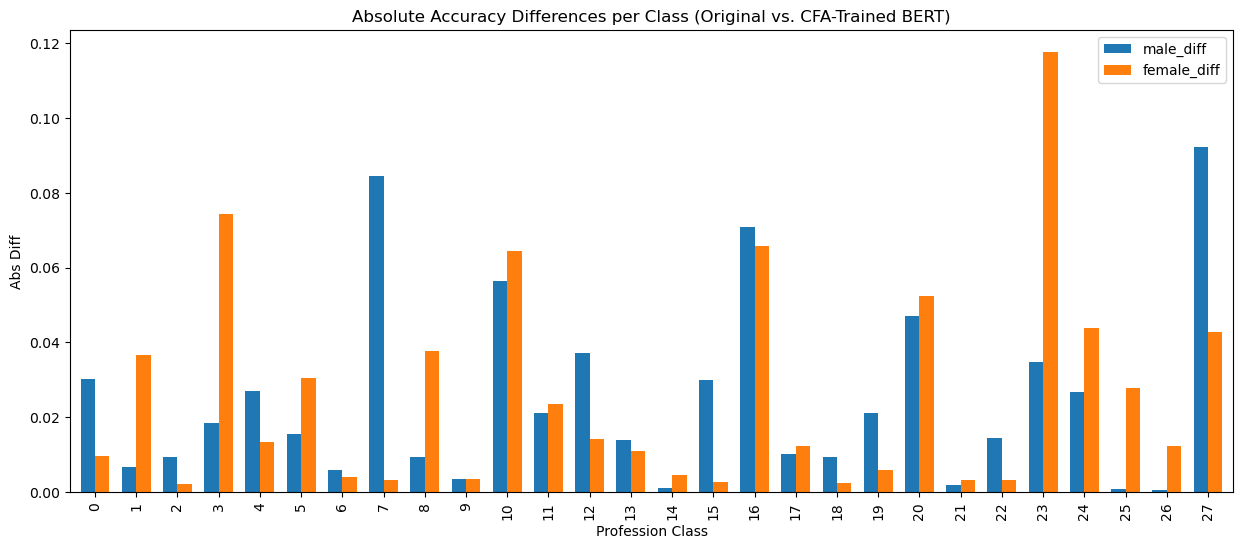

In [ ]:
# Overall comparison on original test
print("\nComparison on Original Test:")
print("Original Accuracy:", accuracy_score(y_test_np, y_pred_np))
print("CFA-Trained Accuracy:", accuracy_score(y_test_np, y_pred_cfa_orig))
print("Original Macro F1:", f1_score(y_test_np, y_pred_np, average='macro'))
print("CFA-Trained Macro F1:", f1_score(y_test_np, y_pred_cfa_orig, average='macro'))

# Per-class gender accuracy diffs
orig_male_acc = male_accuracy  # From original BERT
orig_female_acc = female_accuracy
cfa_male_acc = male_accuracy_cfa_orig
cfa_female_acc = female_accuracy_cfa_orig

diff_male = np.abs(np.array(orig_male_acc) - np.array(cfa_male_acc))
diff_female = np.abs(np.array(orig_female_acc) - np.array(cfa_female_acc))

print("\nAbs Male Accuracy Diff per Class (Original - CFA-Trained):", diff_male)
print("Abs Female Accuracy Diff per Class (Original - CFA-Trained):", diff_female)

# Plot diffs
pd.DataFrame({
    "group": list(range(num_labels)),
    "male_diff": diff_male,
    "female_diff": diff_female
}).set_index('group').plot(kind='bar', width=0.7, figsize=(15, 6))
plt.title("Absolute Accuracy Differences per Class (Original vs. CFA-Trained BERT)")
plt.ylabel("Abs Diff")
plt.xlabel("Profession Class")
plt.show()